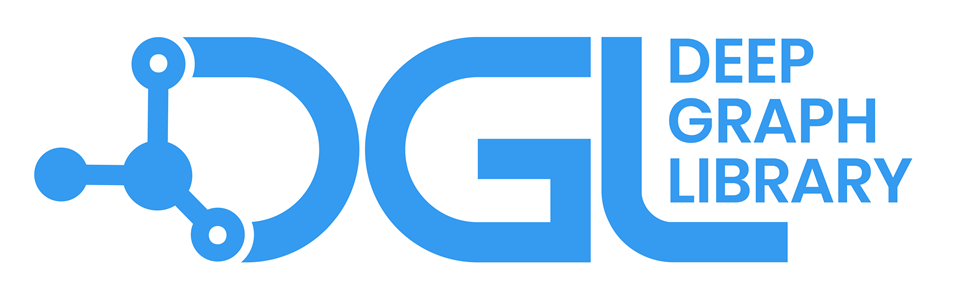

* Deep Graph Library (DGL) is a Python package built for easy implementation of graph neural network model family, on top of existing DL frameworks (currently supporting PyTorch, MXNet and TensorFlow).
* Different from networkx, it supports training graph neural network. 

In [3]:
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch as th

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Graph, Nodes and Edegs



*   We create graph using dgl.graph from (u, v): 
    
    u/v: a sequence of source/target node ids 
    
    u/v are represented in pytorch 1-d tensors


*   Accessing nodes/edges:

    g.nodes()

    g.edegs()


*   By default, edges are directed

    create undirected graph (providing both directions)

    use dgl.to_bidirected(g)


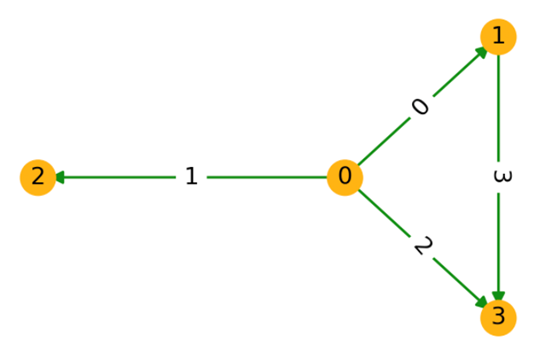

In [20]:
# edges 0->1, 0->2, 0->3, 1->3
u, v = th.tensor([0, 0, 0, 1]), th.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
print(g) # number of nodes are inferred from the max node IDs in the given edges


Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})


In [21]:
# Node IDs
print(g.nodes())

tensor([0, 1, 2, 3])


In [22]:
# Edges 0->1, 0->2, 0->3, 1->3
print(g.edges())

(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]))


In [23]:
# Edges and edge IDs
print(g.edges(form='all'))

(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]), tensor([0, 1, 2, 3]))


In [24]:
# Convert to undirected/bidirected graph
bg = dgl.to_bidirected(g)
bg.edges()

(tensor([0, 0, 0, 1, 1, 2, 3, 3]), tensor([1, 2, 3, 0, 3, 0, 0, 1]))

# Features of Nodes and Edges

* Node features: g.ndata[‘name’]

* Edge features: g.edata[‘name’]

* 1node/edge versus 1feature

* Features must be pytorch tensors

* Same feature name for nodes/edges is OK.


In [25]:
g = dgl.graph(([0, 0, 1, 5], [1, 2, 2, 0])) # 6 nodes, 4 edges
print(g)

Graph(num_nodes=6, num_edges=4,
      ndata_schemes={}
      edata_schemes={})


In [26]:
g.ndata['x'] = th.ones(g.num_nodes(), 3)               # node features (num_nodes, 3), 3 is the feature dimension
print(g.ndata['x'])

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [27]:
g.edata['x'] = th.ones(g.num_edges(), dtype=th.int32)  # scalar integer edge features (num_edges, )
print(g.edata['x'])

tensor([1, 1, 1, 1], dtype=torch.int32)


In [28]:
print(g)

Graph(num_nodes=6, num_edges=4,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(), dtype=torch.int32)})


In [29]:
# node/edge features can have the same name
print('\'x\' feature of node 1:', g.ndata['x'][1])   # get node 1's feature
print('\'x\' feature of edge 0 and 3:', g.edata['x'][th.tensor([0, 3])])  # get features of edge 0 and 3

'x' feature of node 1: tensor([1., 1., 1.])
'x' feature of edge 0 and 3: tensor([1, 1], dtype=torch.int32)


# Graph Neural Network Layers

## Graph Convolution Network

Reference paper: [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)

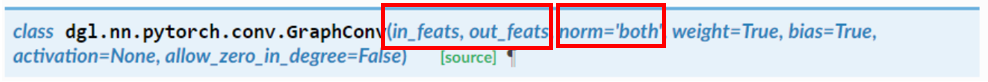

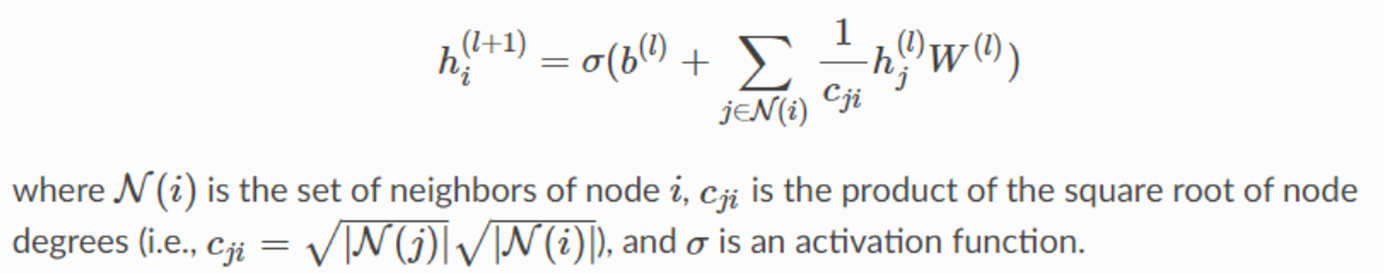



*   $h_{i}^{l}$: features of node $i$ at layer $l$

*   $W^{l}, b^{l}$: learnable parameters at layer $l$ 

*   in_feats: dimension of the input node features at this layer

*   out_feats: dimension of the output node features at this layer 



### norm:

* right: to divide the aggregated messages by each node’s in-degrees, which is equivalent to averaging the received messages.

* none: where no normalization is applied.

* both (default): where the messages are scaled with 1/cji above, equivalent to symmetric normalization.

* left: to divide the messages sent out from each node by its out-degrees, equivalent to random walk normalization.

In [30]:
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))  # Creta a graph
g = dgl.add_self_loop(g)  # Adding self-loop, otherwise the aggregation function might be applied on empty input 
print(g)

Graph(num_nodes=6, num_edges=12,
      ndata_schemes={}
      edata_schemes={})


In [31]:
g.edges()

(tensor([0, 1, 2, 3, 2, 5, 0, 1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 0, 3, 0, 1, 2, 3, 4, 5]))

In [32]:
feat = th.ones(6, 10) # Crate features for the 6 nodes using pytorch tensor
print(feat)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [33]:
from dgl.nn import GraphConv
conv = GraphConv(10, 2, norm='both', weight=True, bias=True) # create a graph convolution layer
print(conv)

GraphConv(in=10, out=2, normalization=both, activation=None)


In [34]:
res = conv(g, feat)  # apply the conv layer on the node features of g
print(res)  # see how it's different from all ones when defined 

tensor([[-0.0531, -0.6536],
        [-0.0585, -0.7197],
        [-0.0531, -0.6536],
        [-0.0672, -0.8275],
        [-0.0706, -0.8687],
        [-0.0413, -0.5089]], grad_fn=<AddBackward0>)


## GraphSage

Reference paper: [Inductive Representation Learning on Large Graphs](https://arxiv.org/pdf/1706.02216.pdf)

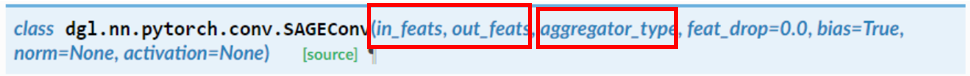

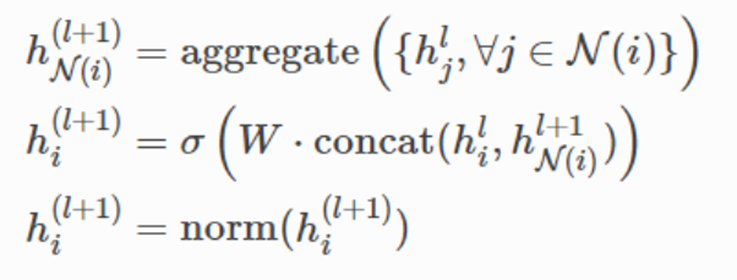



*   $h^{l}_{i}$: features of node $i$ at layer $l$

*   $W$: learnable parameters 

*   $h^{(l+1)}_{N(i)}$: aggregated features of the neighbours of node $i$ at layer $l+1$

*   concat: connect two node features.

*   aggregate: operation to aggregate the messages from neighbour nodes. (e.g., mean, pool)



In [35]:
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))  # Creta a graph
g = dgl.add_self_loop(g)  # Adding self-loop, otherwise the aggregation function will be applied on empty input 
print(g)

Graph(num_nodes=6, num_edges=12,
      ndata_schemes={}
      edata_schemes={})


In [36]:
feat = th.ones(6, 10) # Crate features for the 6 nodes using pytorch tensor
print(feat)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [37]:
from dgl.nn import SAGEConv
conv = SAGEConv(10, 2, 'mean') # input_dim=10, out_dim=2, aggregation=mean
print(conv)

SAGEConv(
  (feat_drop): Dropout(p=0.0, inplace=False)
  (fc_neigh): Linear(in_features=10, out_features=2, bias=False)
  (fc_self): Linear(in_features=10, out_features=2, bias=True)
)


In [38]:
res = conv(g, feat)  # apply the conv layer on the node features of g
print(res)  # see how it's different from all ones when defined 

tensor([[-0.7335, -0.4895],
        [-0.7335, -0.4895],
        [-0.7335, -0.4895],
        [-0.7335, -0.4895],
        [-0.7335, -0.4895],
        [-0.7335, -0.4895]], grad_fn=<AddBackward0>)


# Build a GNN with GraphConv



*   We use torch.nn.Module to wrap our computation:
    
    1.   main message passing, node feature updating within the  GraphConv class, i.e., h = self.conv(...)
    2.   in torch.nn.Module, we can stack multiple conv layers: h = self.conv1(...), h = F.relu(h), h = self.conv2(...) 
    3.   the 'forward' method executes the computation we defined above


*   in_feats: the dimension of the input node feature
*   h_feats: the dimension of the hidden feature during computing (in_feats->h_feats->...h_feats->out_feats )
*   There's is ReLU actionvation function between Conv layers
*   We will see in later tutorials/assignment, using torch.nn.Module makes it easy to do training/backward in deep learning.



In [39]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, out_feats)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [40]:
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))  # Creta a graph
g = dgl.add_self_loop(g)  # Adding self-loop, otherwise the aggregation function will be applied on empty input 
print(g)

Graph(num_nodes=6, num_edges=12,
      ndata_schemes={}
      edata_schemes={})


In [41]:
feat = th.ones(6, 10) # Crate features for the 6 nodes using pytorch tensor
print(feat)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [42]:
# Create the model with in_dim=10, hidden_dim=4, out_dim=2
model = GCN(feat.shape[1], 4, 2)

In [43]:
res = model(g, feat)  # apply the GNN on the node features of g
print(res)  # see how it's different from all ones when defined 

tensor([[-0.1180,  0.0594],
        [-0.1365,  0.0688],
        [-0.1246,  0.0628],
        [-0.1517,  0.0764],
        [-0.2043,  0.1029],
        [-0.0715,  0.0360]], grad_fn=<AddBackward0>)


# Compute Pairwise Node Feature Dot-Product

This computation is motivated by predicting whether there is a link between any of two nodes $u$, $v$.

The probability of the existance of an edge between node $u$, $v$ can be computed by $\hat{y}_{u \sim v}$ = $\sigma(h_u^{\intercal}h_v)$.

So if we have $N$ nodes, we will get $N \times N$ results. Here we mainly focus on how to compute the dot-products.

Main idea:
*   g.apply_edges() is a method to update the features of the edges given the message from the edge.
*   fn.u_dot_v() generates the message of an edge by computing the dot-product of the incident node features. Taking the name of the, (1) source node feature name, (2) target node fearture name, (3) new edge feautre to be saved.

with g.local_scope(): Within this context, any modification to the graph object $g$ is not effective. 

In [47]:
import dgl.function as fn

class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [44]:
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))  # Creta a graph
g = dgl.add_self_loop(g)  # Adding self-loop, otherwise the aggregation function will be applied on empty input 
print(g)

Graph(num_nodes=6, num_edges=12,
      ndata_schemes={}
      edata_schemes={})


In [45]:
feat = th.ones(6, 10) # Crate features for the 6 nodes using pytorch tensor
print(feat)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [48]:
# Create the computing module
link_pred = Score()

In [49]:
res = link_pred(g, feat)  # apply the module on the node features of g
print(res)  # check if the dot-product is correctly computed.  

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])


# Next Time


* Next time Assignment2 will be released.

* We will introduce how to carry out training of node classification/clustering/link prediction with GNN. That is, how to obtain the parameters of the conv layer/networks. This time we only define the computation, leaving the parameters randomly initialized.

* Some basics about PyTorch and deep learning training will be covered.

* We will also cover K-Means clustering for node clustering.